# Linear transformations with images
In this module we will work with linearly aligning images.  We'll apply transformations to images, and estimate optimal transformations.  Here problems will be nonlinear, and we'll need to use iterative methods.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import nibabel as nib
import os
import summerschool as ss
import scipy.interpolate as spi

## Load some data

In [2]:
fname = os.path.join('mouse_images','PMD2052_orig_target_STS_clean.img')
img = nib.load(fname)
# load the image
I = img.get_data()[:,:,:,0] # note last axes is time, we'd like to remove it
# downsample so it can run on people's laptops
down = 3
I = ss.downsample_image(I,down)
# get voxeldx = img.header['pixdim'][1:4]*down voxel size and number of voxels
# note all the images in this dataset are in MNI space and are the same size and shape
nx = I.shape
dx = img.header['pixdim'][1:4]*down
# set up a domain
x0 = np.arange(nx[0])*dx[0]
x1 = np.arange(nx[1])*dx[1]
x2 = np.arange(nx[2])*dx[2]
# lets define the origin to be in the middle of our image
# linear transformations will be more reasonable this way
x0 = x0 - np.mean(x0)
x1 = x1 - np.mean(x1)
x2 = x2 - np.mean(x2)
X0,X1,X2 = np.meshgrid(x0,x1,x2,indexing='ij')

<IPython.core.display.Javascript object>


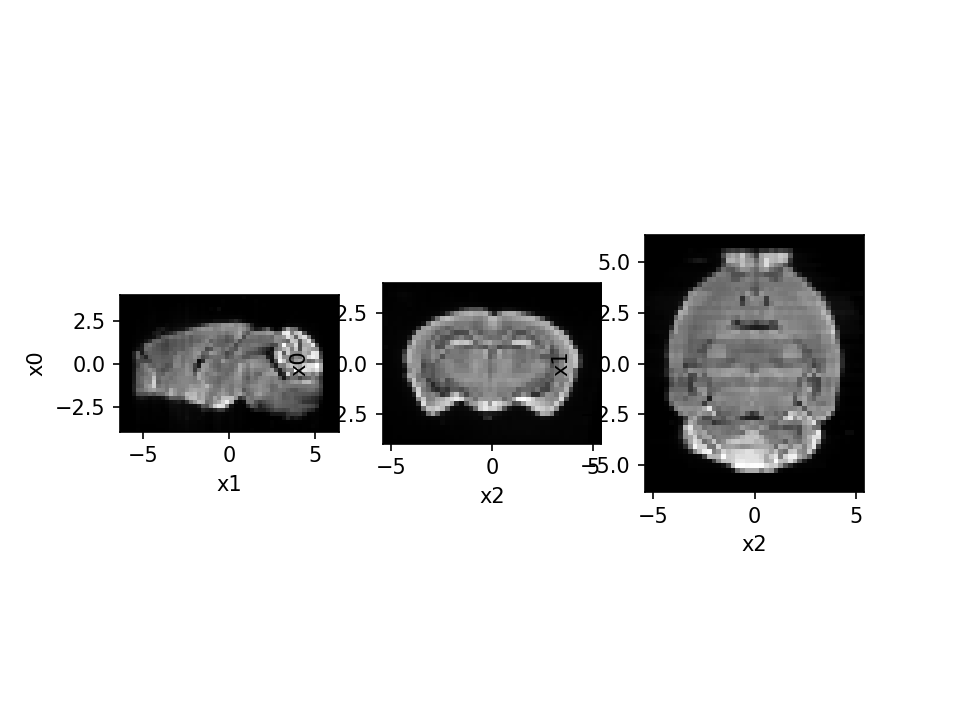

In [3]:
ss.imshow_slices(x0,x1,x2,I)

## Transformations act on images through their inverse



## Images are deformed by sampling them at new points: interpolation

In [4]:
interp_args = {
    'method':'linear', # this says how we'd like to do interpolation, linear is fast and smooth
    'bounds_error':False, # if we try to sample outside the image, do not raise an error
    'fill_value':0 # if we try to sample outside the image, we'll return the value 0
}

In [5]:
# A 2D example image
I2d = np.array(I[:,:,I.shape[-1]//2])
X02d = X0[:,:,0]
X12d = X1[:,:,0]

<IPython.core.display.Javascript object>


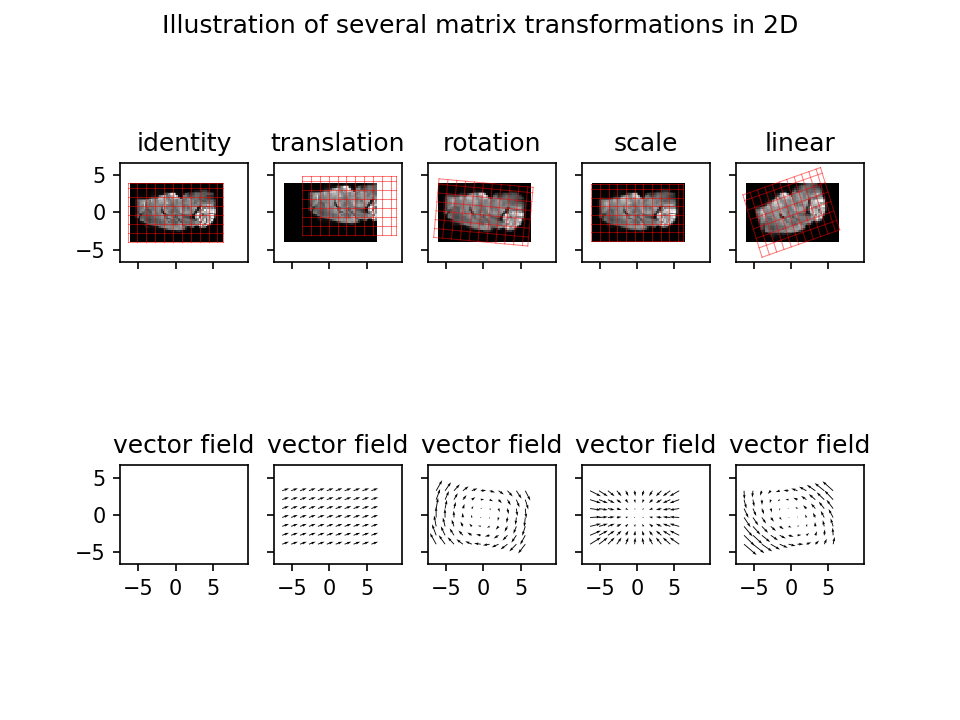

Text(0.5,0.98,'Illustration of several matrix transformations in 2D')

In [6]:
# make a figure
nplots = 5
f,ax = plt.subplots(2, nplots, sharex=True, sharey=True)
for i in range(nplots):
    ax_ = ax[:,i]
    # choose a transformation
    if i == 0:
        A = np.eye(3)
        titlestring = 'identity'
    elif i == 1:
        T = np.random.randn(2)*2.0
        A = np.array([[1,0,T[0]],[0,1,T[1]],[0,0,1]])
        titlestring = 'translation'
    elif i == 2:
        theta = np.random.rand()*2.0*np.pi/6.0
        A = np.eye(3)
        A[:2,:2]= [[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]]
        titlestring = 'rotation'
    elif i==3:
        s = np.random.randn()*0.1 + 1.0
        A = np.eye(3)
        A[:2,:2] = np.eye(2)*s
        titlestring = 'scale'
    elif i == 4:
        A = np.eye(3)
        A[:2,:2] += np.random.randn(2,2)*0.2
        titlestring = 'linear' 
    
    # make a transformed grid
    AX0 = A[0,0]*X02d + A[0,1]*X12d + A[0,2]
    AX1 = A[1,0]*X02d + A[1,1]*X12d + A[1,2]
    stride = 5
    ss.plot_grid(AX1, AX0, ax=ax_[0], 
                 rstride=stride, cstride=stride,
                 color='r', linewidth=0.5, alpha=0.5)
    
    # make a transformed image
    B = np.linalg.inv(A)
    X0s = B[0,0]*X02d + B[0,1]*X12d + B[0,2]
    X1s = B[1,0]*X02d + B[1,1]*X12d + B[1,2]
    AI = spi.interpn([x0,x1],I2d,np.stack([X0s,X1s],axis=-1),**interp_args)
    ax_[0].imshow(AI, cmap='gray', 
                  extent=[x1[1],x1[-1],x0[0],x0[-1]], origin='lower') # make sure you set extent and origin!
    
    ax_[0].set_aspect('equal')
    ax_[0].set_title(titlestring)

    # let's show the vector field
    ax_[1].quiver(X12d[::stride,::stride], X02d[::stride,::stride], 
                  AX1[::stride,::stride]-X12d[::stride,::stride], 
                  AX0[::stride,::stride]-X02d[::stride,::stride])
    ax_[1].set_aspect('equal')
    ax_[1].set_title('vector field')
f.suptitle('Illustration of several matrix transformations in 2D')

<IPython.core.display.Javascript object>


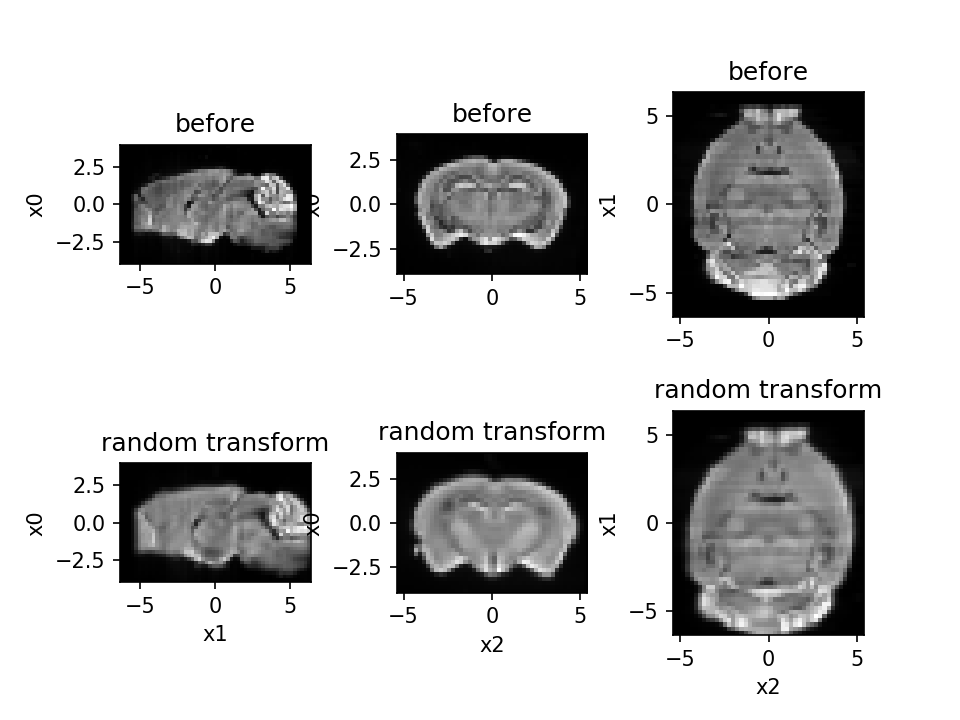

In [7]:
# construct a transformation
A = np.eye(4)
A[:3,:3] += np.random.randn(3,3)*0.05 # a random deformation
A[:3,-1] += np.random.randn(3)*1.0 # a random shift
def sample_points_from_affine(X0,X1,X2,A):
    # find its inverse, using homogeneous coordinates
    B = np.linalg.inv(A)
    # get the sample points by matrix multiplication
    X0s = B[0,0]*X0 + B[0,1]*X1 + B[0,2]*X2 + B[0,3]
    X1s = B[1,0]*X0 + B[1,1]*X1 + B[1,2]*X2 + B[1,3]
    X2s = B[2,0]*X0 + B[2,1]*X1 + B[2,2]*X2 + B[2,3]
    return X0s,X1s,X2s    
# this is defined in the summer school module
X0s,X1s,X2s = ss.sample_points_from_affine(X0,X1,X2,A)
AI = spi.interpn(
    [x0,x1,x2], # this labels where in space each voxel is
    I, # this says the intensity of our image at each voxel
    np.stack([X0s,X1s,X2s],axis=-1), # this says where we'd like to evaluate the image
    **interp_args # some more arguments that we defined above
)
f,ax=plt.subplots(2,3)
plt.subplots_adjust(wspace=0.45,hspace=0.35)
ss.imshow_slices(x0,x1,x2,I,ax[0])
for a in ax[0]: 
    a.set_title('before')
    a.set_xlabel('')
ss.imshow_slices(x0,x1,x2,AI,ax[1])
for a in ax[1]: a.set_title('random transform')
Irandom = AI

## Computing optimal transformations
As with points, we will write down a sum of square error cost
\begin{align*}
E(A) = \int_X \frac{1}{2}(I(A^{-1}x) - J(x))^2 dx
\end{align*}

And as before we'll take it's gradient with respect to $A$.  Since $A$ is a matrix, we'll consider an arbitrary perturbation to $A$, $A\mapsto A + \epsilon \delta A$, and take the gradient with respect to $\epsilon$ for any perturbation.
\begin{align*}
E(\epsilon) = \int_X \frac{1}{2}(I( (A + \epsilon \delta A)^{-1}x) - J(x))^2 dx
\end{align*}
We will use the fact that
\begin{align}
\frac{d}{d\epsilon}E(\epsilon) \bigg|_{\epsilon = 0} = \text{trace} \nabla E^T \delta A
\end{align}
This is just the definition of the directional derivative, as the gradient dot the directoin.

We are interested in
\begin{align*}
\frac{d}{d\epsilon}E(\epsilon) \bigg|_{\epsilon = 0}
\end{align*}

Let's attack this expression using the chain rule, first attack the square term
\begin{align*}
&= \int_X (I((A + \epsilon \delta A)^{-1}x) - J(x)) \frac{d}{d\epsilon} I((A + \epsilon \delta A)^{-1}x)dx \bigg|_{\epsilon = 0}\\
&=\int_X (I(A^{-1}x) - J(x)) \frac{d}{d\epsilon} I((A + \epsilon \delta A)^{-1}x)dx \bigg|_{\epsilon = 0}\\
\end{align*}
Now attack the image
\begin{align*}
&= \int_X (I(A^{-1}x) - J(x))  DI((A + \epsilon \delta A)^{-1}x) \frac{d}{d\epsilon} (A + \epsilon \delta A)^{-1}x dx \bigg|_{\epsilon = 0}\\
&= \int_X (I(A^{-1}x) - J(x))  DI(A^{-1}x) \frac{d}{d\epsilon} (A + \epsilon \delta A)^{-1}\bigg|_{\epsilon = 0} x dx \\
\end{align*}
Now the final term depends on taking the derivative of the inverse of a matrix.  Consider an arbitrary matrix $M$ that is a function of a parameter $t$.  We can work out the derivative of the inverse by
\begin{align*}
\frac{d}{dt}M^{-1}(t) &=\frac{d}{dt}\left( M^{-1}(t)M(t)M^{-1}(t) \right)\\
&= \frac{d}{dt}M^{-1}(t) M(t) M^{-1}(t) + M^{-1}(t) \frac{d}{dt}M(t) M^{-1}(t) + M^{-1}(t)M(t) \frac{d}{dt}M^{-1}(t)\\
 &=\frac{d}{dt}\left( M^{-1}(t)M(t)M^{-1}(t) \right)\\
&= \frac{d}{dt}M^{-1}(t) + M^{-1}(t) \frac{d}{dt}M(t) M^{-1}(t) + \frac{d}{dt}M^{-1}(t)\\
\end{align*}
Rearranging gives
\begin{align*}
\frac{d}{dt}M^{-1}(t) = - M^{-1}(t) \frac{d}{dt}M(t) M^{-1}(t)
\end{align*}
So in our problem we have
\begin{align*}
\frac{d}{dt}(A + \epsilon \delta A)^{-1} &= -(A + \epsilon \delta A)^{-1} \delta A (A + \epsilon \delta A)^{-1}
\end{align*}
Plugging this in with $\epsilon = 0$ gives the result
\begin{align*}
\frac{d}{d\epsilon}E(\epsilon) \bigg|_{\epsilon = 0} = -\int_X (I(A^{-1}x) - J(x))  DI(A^{-1}x) A^{-1}\delta A A^{-1} x dx 
\end{align*}
Finally we can simplify this by recalling that $D[I(A^{-1}x)] = DI(A^{-1}x)A^{-1}$, giving
\begin{align*}
= -\int_X (I(A^{-1}x) - J(x))  D[I(A^{-1}x)]\delta A A^{-1} x dx 
\end{align*}
Finally to work out the gradient with respect to $A$, we have to write this expression as a gradient, dot $\delta A$.  Taking the dot product on matrices using the trace gives
\begin{align*}
&= -\int_X \text{trace}(I(A^{-1}x) - J(x))  D[I(A^{-1}x)]\delta A A^{-1} x dx \\
&= -\int_X \text{trace}A^{-1} x (I(A^{-1}x) - J(x))  D[I(A^{-1}x)] dx \delta A
\end{align*}
which gives a gradient of 
\begin{align*}
-\int_X (I(A^{-1}x)-J) \nabla[I(A^{-1}x)](A^{-1}x)^Tdx
\end{align*}

We will use this to build a gradient descent algorithm.  This is an iterative method, where we update date our current guess of $A$ by taking a "small step downhill", i.e. a small step in the direction opposite to the gradient.

<IPython.core.display.Javascript object>


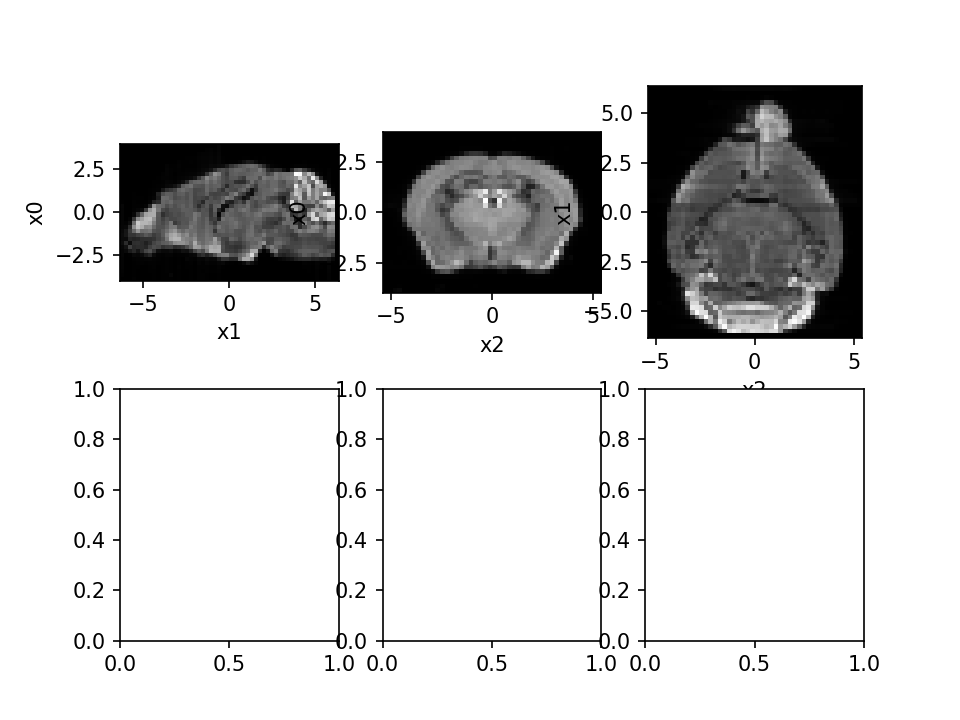

"\n# note that these human MRI images have already been affine aligned into MNI space\n# let's add a small affine transformation and then try to recover it\nA = np.eye(4)\nA[:3,:3] += np.random.randn(3,3)*0.05 # a random deformation\nA[:3,-1] += np.random.randn(3)*2.0 # a random shift\nX0s,X1s,X2s = ss.sample_points_from_affine(X0,X1,X2,A)\nJ = spi.interpn([x0,x1,x2],J,np.stack([X0s,X1s,X2s],axis=-1),**interp_args)\nss.imshow_slices(x0,x1,x2,J,ax[1])\n"

In [8]:
# load a second image to map to
fname = os.path.join('mouse_images','PMD3097_orig_target_STS_clean.img')
img = nib.load(fname)
J = img.get_data()[:,:,:,0] # note last axes is time, we'd like to remove it
J = ss.downsample_image(J,down)
f,ax = plt.subplots(2,3)
ss.imshow_slices(x0,x1,x2,J,ax[0])
'''
# note that these human MRI images have already been affine aligned into MNI space
# let's add a small affine transformation and then try to recover it
A = np.eye(4)
A[:3,:3] += np.random.randn(3,3)*0.05 # a random deformation
A[:3,-1] += np.random.randn(3)*2.0 # a random shift
X0s,X1s,X2s = ss.sample_points_from_affine(X0,X1,X2,A)
J = spi.interpn([x0,x1,x2],J,np.stack([X0s,X1s,X2s],axis=-1),**interp_args)
ss.imshow_slices(x0,x1,x2,J,ax[1])
'''

<IPython.core.display.Javascript object>


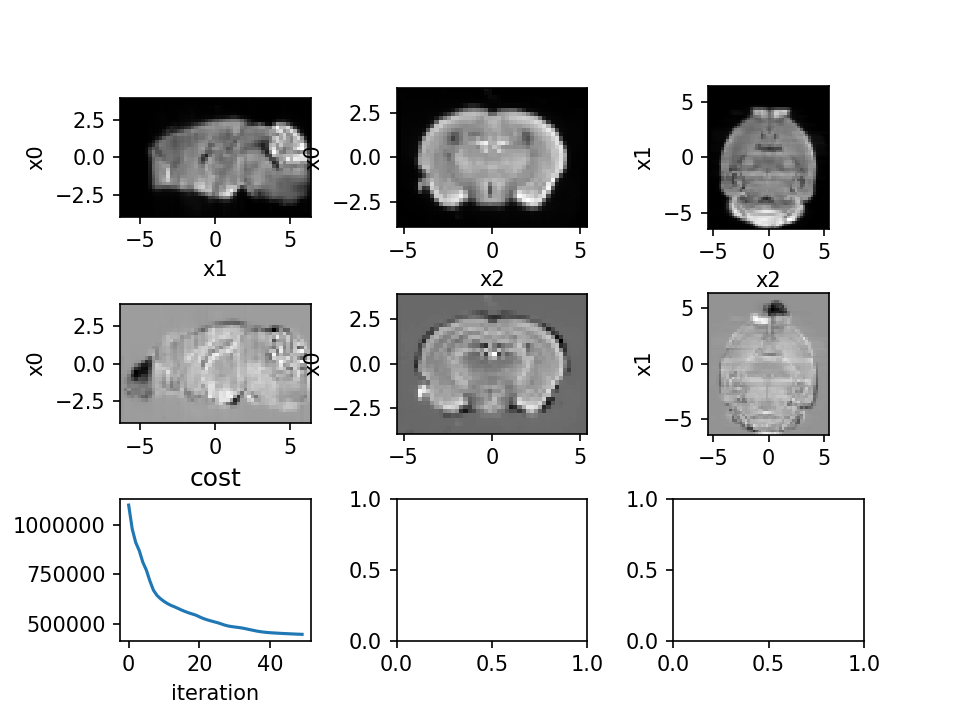

In [9]:
# initialize a transformation
A = np.eye(4)
# choose a gradient descent step size
# note that the linear part and the translation part often need to be on very different scales
# for human
epsilonL = 1.0e-12
epsilonT = 1.0e-9
# for mouse
epsilonL = 1.0e-8
epsilonT = 1.0e-7

niter = 50
EAll = []
f,ax = plt.subplots(3,3)
plt.subplots_adjust(wspace=0.45,hspace=0.45)
for it in range(niter):
    # find the deformed image    
    X0s,X1s,X2s = ss.sample_points_from_affine(X0,X1,X2,A)
    AI = spi.interpn([x0,x1,x2],I,np.stack([X0s,X1s,X2s],axis=-1),**interp_args)
    ss.imshow_slices(x0,x1,x2,AI,ax[0])
    
    # get the error
    err = AI-J
    ss.imshow_slices(x0,x1,x2,err,ax[1])
    for a in ax[1]: a.set_xlabel('')
    
    # find the gradient
    AI_0,AI_1,AI_2 = np.gradient(AI,dx[0],dx[1],dx[2])
    
    # calculate energy
    E = np.sum(err**2*0.5)*np.prod(dx)
    EAll.append(E)
    ax[2,0].cla()
    ax[2,0].plot(EAll)
    ax[2,0].set_title('cost')
    ax[2,0].set_xlabel('iteration')
    # find the gradient of the linear part
    gradL = np.empty((3,3))
    for i,AI_i in enumerate([AI_0,AI_1,AI_2]):
        for j,AX_j in enumerate([X0s,X1s,X2s]):
            gradL[i,j] = -np.sum(err*AI_i*AX_j)*np.prod(dx)
    # find the gradient of the translation part
    gradT = np.empty(3)
    for i,AI_i in enumerate([AI_0,AI_1,AI_2]):
        gradT[i] = -np.sum(err*AI_i)*np.prod(dx)
    # update
    A[:3,:3] -= epsilonL*gradL
    A[:3,-1] -= epsilonT*gradT
    
    f.canvas.draw()
    
# let's write out the transformation for the next tutorial
with open('affine.txt','wt') as f:
    for i in range(4):
        for j in range(4):
            f.write('{} '.format(A[i,j]))
        f.write('\n')
    

## Rigid transformations
Above we considered perturbations of the form $A \mapsto \epsilon \delta A$.

With rigid transforms we cannot add like this.

But we know that small perturbations to the rotation group correspond to antisymmetric matrices.  We can write
\begin{align*}
A \mapsto \exp(\epsilon \delta A) A \simeq (Id + \epsilon \delta A)A
\end{align*}
where $\exp$ is the matrix exponential.  Repeating the above derivations with this analysis can tell us how to optimize over the rotation group.

